In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load cleaned data
print("Loading cleaned heart failure data...")
hf_clean = pd.read_csv('../datasets/heart_failure_cleaned.csv')

# Load additional datasets for feature enrichment
print("Loading additional datasets for feature engineering...")
labevents = pd.read_csv('../datasets/labevents_202208161605.csv', nrows=100000)
d_labitems = pd.read_csv('../datasets/d_labitems_202208161605.csv')
procedures_icd = pd.read_csv('../datasets/procedures_icd_202208161605.csv')
cptevents = pd.read_csv('../datasets/cptevents_202208161605.csv')
drgcodes = pd.read_csv('../datasets/drgcodes_202208161605.csv')

print("Additional datasets loaded successfully.")

Loading cleaned heart failure data...
Loading additional datasets for feature engineering...
Additional datasets loaded successfully.


In [4]:
# 1. Laboratory Features
print("\n=== LABORATORY FEATURE ENGINEERING ===")

# Merge lab events with lab items to get test names
lab_merged = labevents.merge(d_labitems, on='itemid', how='left')

# Select common lab tests (you can expand this list)
common_lab_tests = [
    'Sodium', 'Potassium', 'Chloride', 'Bicarbonate', 'Anion Gap',
    'Glucose', 'Creatinine', 'Urea Nitrogen', 'Calcium', 'Magnesium',
    'Phosphate', 'Hemoglobin', 'Hematocrit', 'White Blood Cells',
    'Platelet Count', 'Red Blood Cells'
]

lab_features = lab_merged[lab_merged['label'].isin(common_lab_tests)]

# Aggregate lab values by admission
lab_agg = lab_features.groupby(['hadm_id', 'label']).agg({
    'valuenum': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()


=== LABORATORY FEATURE ENGINEERING ===


In [5]:
# Flatten column names
lab_agg.columns = ['hadm_id', 'label', 'mean_val', 'std_val', 'min_val', 'max_val', 'count_val']

# Pivot to create features
lab_pivot = lab_agg.pivot_table(
    index='hadm_id', 
    columns='label', 
    values=['mean_val', 'std_val', 'min_val', 'max_val', 'count_val'],
    fill_value=0
)

# Flatten column names
lab_pivot.columns = [f"{col[0]}_{col[1].replace(' ', '_')}" for col in lab_pivot.columns]
lab_pivot = lab_pivot.reset_index()

print(f"Laboratory features shape: {lab_pivot.shape}")

# 2. Procedure Features
print("\n=== PROCEDURE FEATURE ENGINEERING ===")

# Count procedures per admission
procedure_count = procedures_icd.groupby('hadm_id').size().reset_index(name='procedure_count')

Laboratory features shape: (211, 76)

=== PROCEDURE FEATURE ENGINEERING ===


In [6]:
# Procedure complexity (based on sequence number)
procedure_complexity = procedures_icd.groupby('hadm_id').agg({
    'seq_num': ['max', 'mean']
}).reset_index()
procedure_complexity.columns = ['hadm_id', 'max_procedure_seq', 'mean_procedure_seq']

procedure_features = procedure_count.merge(procedure_complexity, on='hadm_id', how='left')

print(f"Procedure features shape: {procedure_features.shape}")

# 3. CPT Features
print("\n=== CPT FEATURE ENGINEERING ===")

# Count CPT events per admission
cpt_count = cptevents.groupby('hadm_id').size().reset_index(name='cpt_count')

# Cost center distribution
cost_center_dummy = pd.get_dummies(cptevents['costcenter'], prefix='cost_center')
cpt_merged = pd.concat([cptevents[['hadm_id']], cost_center_dummy], axis=1)
cost_center_agg = cpt_merged.groupby('hadm_id').sum().reset_index()

cpt_features = cpt_count.merge(cost_center_agg, on='hadm_id', how='left')

print(f"CPT features shape: {cpt_features.shape}")

# 4. DRG Features
print("\n=== DRG FEATURE ENGINEERING ===")

# DRG severity and mortality scores
drg_features = drgcodes.groupby('hadm_id').agg({
    'drg_severity': ['mean', 'max'],
    'drg_mortality': ['mean', 'max']
}).reset_index()

drg_features.columns = ['hadm_id', 'mean_drg_severity', 'max_drg_severity', 
                        'mean_drg_mortality', 'max_drg_mortality']

print(f"DRG features shape: {drg_features.shape}")

# Merge all features
print("\n=== MERGING ALL FEATURES ===")

# Start with base features
final_features = hf_clean.copy()

# Merge laboratory features
final_features = final_features.merge(lab_pivot, on='hadm_id', how='left')

# Merge procedure features
final_features = final_features.merge(procedure_features, on='hadm_id', how='left')

# Merge CPT features
final_features = final_features.merge(cpt_features, on='hadm_id', how='left')

# Merge DRG features
final_features = final_features.merge(drg_features, on='hadm_id', how='left')

print(f"Final feature set shape: {final_features.shape}")

Procedure features shape: (52243, 4)

=== CPT FEATURE ENGINEERING ===
CPT features shape: (44148, 4)

=== DRG FEATURE ENGINEERING ===
DRG features shape: (58890, 5)

=== MERGING ALL FEATURES ===
Final feature set shape: (21274, 114)


In [7]:
# Handle missing values in new features
print("\nHandling missing values in engineered features...")

# Fill missing lab values with 0 (assuming no tests were done)
lab_cols = [col for col in final_features.columns if 'mean_val' in col or 'std_val' in col 
           or 'min_val' in col or 'max_val' in col or 'count_val' in col]
final_features[lab_cols] = final_features[lab_cols].fillna(0)

# Fill other missing values
final_features['procedure_count'] = final_features['procedure_count'].fillna(0)
final_features['max_procedure_seq'] = final_features['max_procedure_seq'].fillna(0)
final_features['mean_procedure_seq'] = final_features['mean_procedure_seq'].fillna(0)
final_features['cpt_count'] = final_features['cpt_count'].fillna(0)
final_features['mean_drg_severity'] = final_features['mean_drg_severity'].fillna(0)
final_features['max_drg_severity'] = final_features['max_drg_severity'].fillna(0)
final_features['mean_drg_mortality'] = final_features['mean_drg_mortality'].fillna(0)
final_features['max_drg_mortality'] = final_features['max_drg_mortality'].fillna(0)



Handling missing values in engineered features...



=== FEATURE SELECTION ===
Features for selection: 103
Selected 50 features:

Top 20 features by F-score:
                  feature  score  p_value
0          admission_type    NaN      NaN
1      admission_location    NaN      NaN
2      discharge_location    NaN      NaN
3               insurance    NaN      NaN
4                language    NaN      NaN
5                religion    NaN      NaN
6          marital_status    NaN      NaN
7               ethnicity    NaN      NaN
8                  row_id    NaN      NaN
9                  gender    NaN      NaN
10            expire_flag    NaN      NaN
11                    age    NaN      NaN
12                    los    NaN      NaN
13        admission_month    NaN      NaN
14         admission_year    NaN      NaN
15       admission_season    NaN      NaN
16              age_group    NaN      NaN
17           los_category    NaN      NaN
18    count_val_Anion_Gap    NaN      NaN
19  count_val_Bicarbonate    NaN      NaN

=== CORRELA

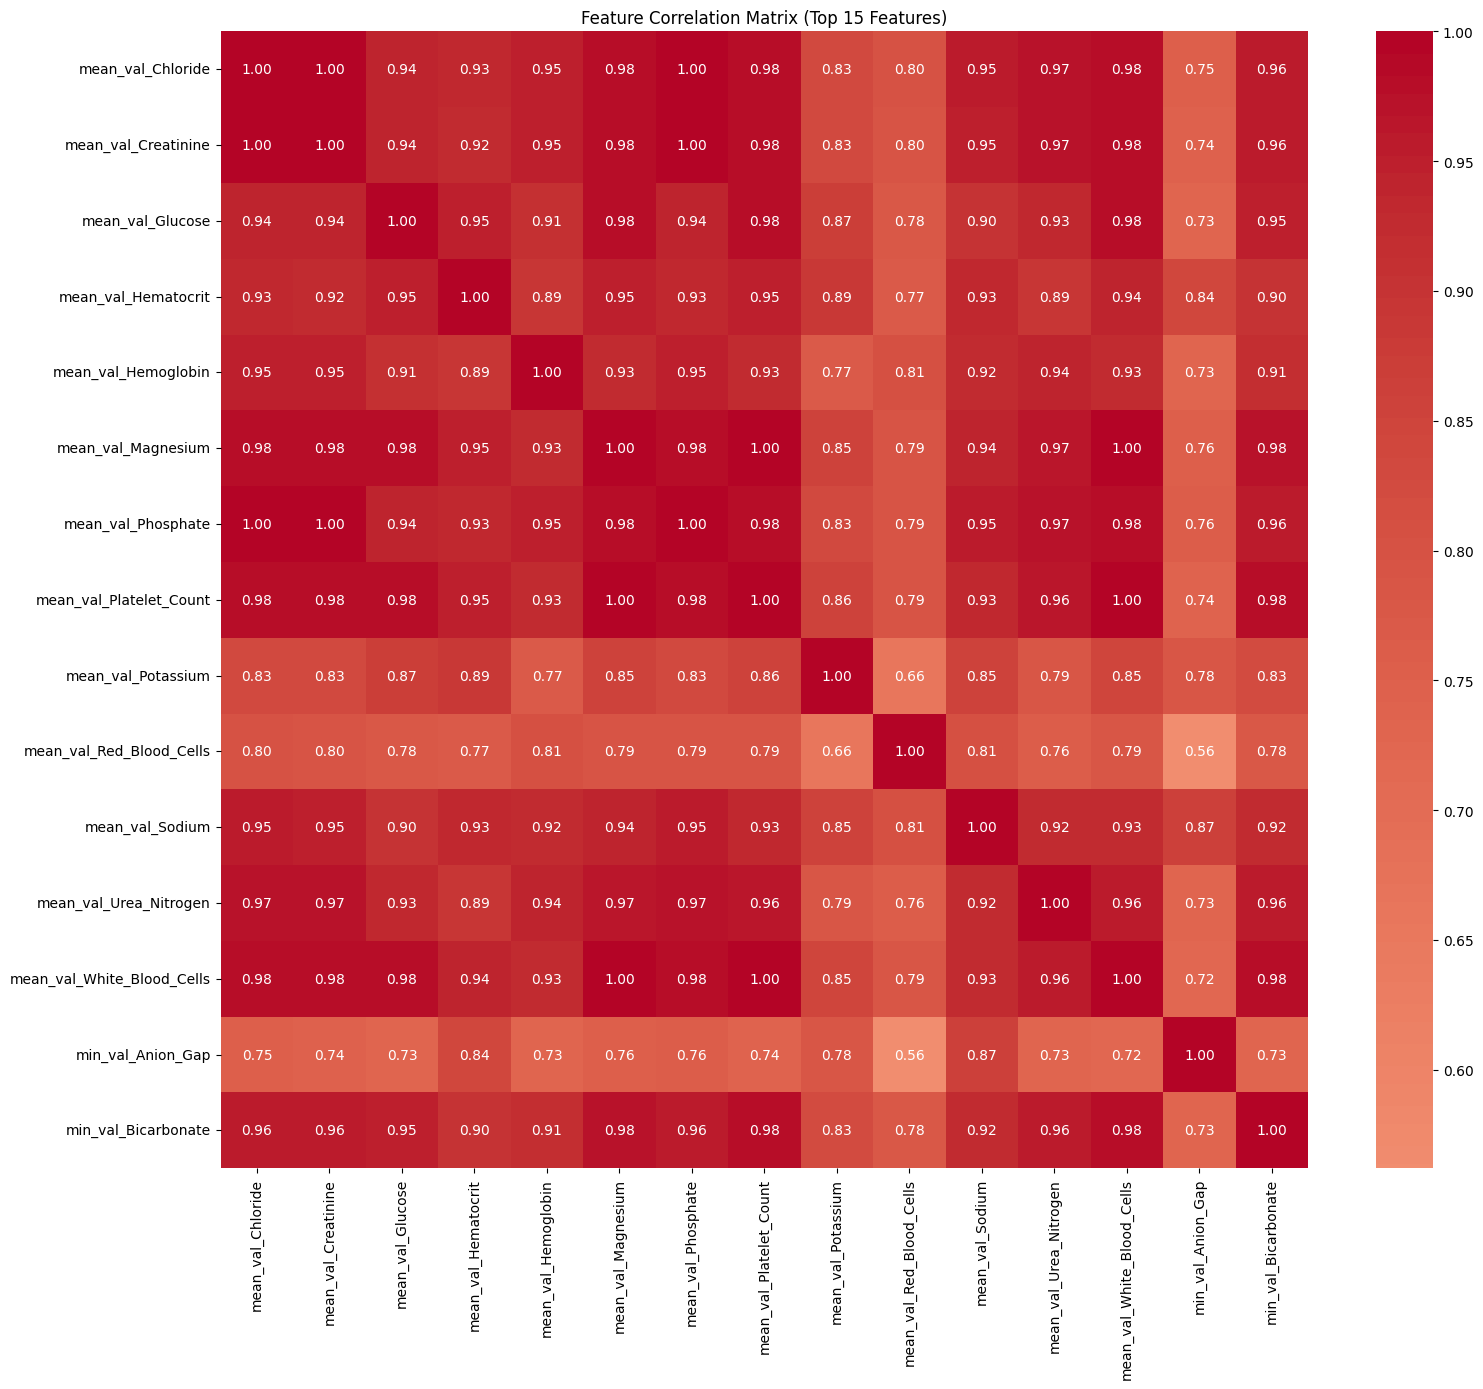


Final dataset shape: (21274, 52)
Number of features: 50

Final feature set saved successfully.

Target variable distribution:
readmission_30
0    1.0
Name: proportion, dtype: float64


In [10]:
# Feature Selection
print("\n=== FEATURE SELECTION ===")

# Prepare data for feature selection
X = final_features.drop(columns=['readmission_30', 'subject_id', 'hadm_id', 'admittime', 
                                'dischtime', 'dob', 'next_admittime', 'days_to_readmit',
                                'icd9_code', 'seq_num', 'hospital_expire_flag'], errors='ignore')
y = final_features['readmission_30']

# Remove non-numeric columns for feature selection
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

print(f"Features for selection: {X_numeric.shape[1]}")

# Univariate Feature Selection
# 🔹 Fix: Handle missing values before feature selection
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # you can also use 'mean'

# Impute missing values safely
X_numeric_imputed = imputer.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric_imputed, columns=X_numeric.columns[:X_numeric_imputed.shape[1]])


# Univariate Feature Selection
selector = SelectKBest(score_func=f_classif, k=min(50, X_numeric.shape[1]))
X_selected = selector.fit_transform(X_numeric, y)


# Get selected features
selected_features = X_numeric.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features:")

# Display feature scores
feature_scores = pd.DataFrame({
    'feature': X_numeric.columns,
    'score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('score', ascending=False)

print("\nTop 20 features by F-score:")
print(feature_scores.head(20))

# Correlation Analysis
print("\n=== CORRELATION ANALYSIS ===")

plt.figure(figsize=(16, 14))
correlation_matrix = X_numeric[selected_features[:15]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix (Top 15 Features)')
plt.tight_layout()
plt.show()

# Create final dataset with selected features
final_selected_features = ['hadm_id', 'readmission_30'] + selected_features
final_dataset = final_features[final_selected_features]

print(f"\nFinal dataset shape: {final_dataset.shape}")
print(f"Number of features: {len(selected_features)}")

# Save final feature set
final_dataset.to_csv('../datasets/heart_failure_final_features.csv', index=False)
print("\nFinal feature set saved successfully.")

# Class distribution
print(f"\nTarget variable distribution:")
print(final_dataset['readmission_30'].value_counts(normalize=True))